# Word Embeddings

![](../figs/intro_nlp/embeddings/embeddings.png)

## What are word embeddings?

Word embeddings are a way of representing words as vectors. The vectors are learned from text data and are able to capture some of the semantic and systactic information of the words. 

For example, the word `cat` is similar to `doc` from the following sentences:

"The cat is lying on the floor and the dog was eating”,
 
"The doc was lying on the floor and the cat was eating”

In a mathematical sense, a word embedding is a parameterized function of the word:

$$ f_{\theta}(w) = \theta $$

where $\theta$ is a vector of real numbers. The vector $\theta$ is the embedding of the word $w$.

In a broad sense, `embedding` refers to a lower-dimensional dense vector representation of a higher-dimensional object.
  - in NLP, this higher-dimensional object will be a document.
  - in computer vision, this higher-dimensional object will be an image.

Examples of embeddings and non-embeddings:

  - **Non-embeddings**:
    - one-hot encoding, bag-of-words, TF-IDF, etc.
    - counts over LIWC dictionary categories.
    - sklearn CountVectorizer count vectors
  - **Embeddings**:
    - word2vec, GloVe, BERT, ELMo, etc.
    - PCA reductions of the word count vectors
    - LDA topic shares
    - compressed encodings from an autoencoder



## Categorical Embeddings

![](../figs/intro_nlp/embeddings/1.png)

Categorical embeddings are a way of representing categorical variables as vectors.

For a binary classification problem with outcome $Y$:
    - If you have a high-dimensional categorical variable $X$, (e.g. 1000 categories), you can represent $X$ as a vector of length 1000.
    - It is computationally expensive for a ML model to learn from a high-dimensional categorical variable.

Instead, you can represent $X$ as a lower-dimensional vector of length $k$ (e.g. 10). This is called a categorical embedding. 

Embedding approaches:

1. PCA applied to the dummy variables $X$ to get a lower-dimensional vector representation of $\tilde{X}$.
2. Regress $Y$ on $X$, predict $\hat{Y}(X_i)$, use that as a feature in a new model.



### An embedding layer is matrix multiplication:

$$
\underbrace{h_1}_{n_E \times 1} = \underbrace{\omega_E}_{n_E \times n_W} \cdot \underbrace{x}_{n_x \times 1} 
$$

- $x$ = a categorical variable (e.g., representing a word)
  - One-hot vector with a single item equaling one.
  - Input to the embedding layer.
- $h_1$ = the first hidden layer of the neural net
  - The output of the embedding layer.
- The embedding matrix $\omega_E$ encodes predictive information about the categories.
- It has a spatial interpretation when projected into 2D space.
  - Each row of $\omega_E$ is a vector in $n_E$-dimensional space.
  - The rows of $\omega_E$ are the coordinates of the points in the vector space.
  - The points are the categories.
  - The distance between the points is the similarity between the categories.
  - The angle between the points is the relationship between the categories.

### Embedding Layers versus Dense Layers

An embedding layer is statistically equivalent to a fully-connected dense layer with one-hot vectors as input and linear activation.

- Embedding layers are much faster for many categories (>~50)

## Word Embeddings

> Word embeddings are neural network layers that map words to dense vectors.


Documents are lists of word indexes ${w_1 ,w_2 ,...,w_{n_i} }$.

- Let $w_i$ be a one-hot vector (dimensionality $n_w$ = vocab size) where the associated word’s index equals one.
- Normalize all documents to the same length L; shorter documents can be padded with a null token.
- This requirement can be relaxed with recurrent neural networks.

The embedding layer replaces the list of sparse one-hot vectors with a list of n E -dimensional ($n_E$ << $n_w$ ) dense vectors

$$ \mathbf{X} = [x_1 \ldots x_L ] $$

where

$$
\underbrace{x_j}_{n_E \times 1} = \underbrace{\mathbf{E}}_{n_E \times n_W} \cdot \underbrace{w_j}_{n_w \times 1}
$$

$\mathbf{E}$ a matrix of word vectors. The column associated with the word at $j$ is selected by the dot-product with one-hot vector $w_j$.

$\mathbf{X}$ is flattened into an $L * n_E$ vector for input to the next layer.


![](../figs/intro_nlp/embeddings/4.png)


### Why do we need neural networks for word embeddings?

There are a lot of shallow algorithms that work well for clustering.
- k-means
- hierarchical clustering
- spectral clustering
- PCA

The reasons we use neural networks for word embeddings are:
- They are able to learn the relationships between words.
- They can be used as input to a downstream task.
- They create a mapping of discrete words to continuous vectors.
- They solve the curse of dimensionality.

## Neural Language Models

Word embeddings were proposed by {cite}`bengio2003neural` as a way to represent words as vectors.

Bengio’s method could train a neural network such that each training sentence could inform the model about a number of semantically available neighboring words, which was known as `distributed representation of words`. The nueural network preserved relationships between words in terms of their contexts (semantic and syntactic).

![](../figs/intro_nlp/embeddings/bengio.png)


This introduced a neural network architecture approach that laid the foundation for many current approaches. 

This neural network has three components:
- **Embedding layer**: maps words to vectors, the parameters are shared across the network.
- **Hidden layer**: a fully connected layer with a non-linear activation function.
- **Output layer**: produces a probability distribution over the vocabulary using a softmax function.

### Step 1: Indexing the words. 

For each word in the sentence, we assign an index.

```python
word_list = " ".join(raw_sentence).split()
word_list = list(set(word_list))
word2id = {w: i for i, w in enumerate(word_list)}
id2word = {i: w for i, w in enumerate(word_list)}
n_class = len(word2id)
```

### Step 2: Building the model.

```python
class NNLM(nn.Module):
    def __init__(self):
        super(NNLM, self).__init__()
        self.embeddings = nn.Embedding(n_class, m) #embedding layer or look up table

        self.hidden1 = nn.Linear(n_step * m, n_hidden, bias=False)
        self.ones = nn.Parameter(torch.ones(n_hidden))

        self.hidden2 = nn.Linear(n_hidden, n_class, bias=False)
        self.hidden3 = nn.Linear(n_step * m, n_class, bias=False) #final layer

        self.bias = nn.Parameter(torch.ones(n_class))

    def forward(self, X):
        word_embeds = self.embeddings(X) # embeddings
        X = word_embeds.view(-1, n_step * m) # first layer
        tanh = torch.tanh(self.ones + self.hidden1(X)) # tanh layer
        output = self.bias + self.hidden3(X) + self.hidden2(tanh) # summing up all the layers with bias
        return word_embeds, output
```

- An embedding layer is a lookup table that maps each word to a vector.
- Once the input index of the word is embedded, it is passed through the first hidden layer with bias added to it.
- The output of the first hidden layer is passed through a tanh activation function.
- The output from the embedding layer is also passed through the final layer where the output of the tanh layer is added to it.


### Step 3: Loss and optimization function.

Now that we have the model, we need to define the loss function and the optimization function.

We are using the cross-entropy loss function and the Adam optimizer.

The cross-entropy loss function is made up of two parts:
- The softmax function: this is used to normalize the output of the model so that the sum of the probabilities of all the words in the vocabulary is equal to one.
- The negative log-likelihood: this is used to calculate the loss.



```python
model = NNLM()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```


### Step 4: Training the model.

Finally, we train the model.


```python
for epoch in range(5000):
    optimizer.zero_grad()
    embeddings, output = model(input_batch)

    # output : [batch_size, n_class], target_batch : [batch_size]
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Predict
predict = model(input_batch).data.max(1, keepdim=True)[1]

# Test
print([sen.split()[:2] for sen in raw_sentence], '->', [id2word[n.item()] for n in predict.squeeze()])
```



### Summary

- Word embeddings are a way to represent words as low-dimensional dense vectors.
- These embeddings have associated learnable vectors, which optimize themselves through back propagation. 
- Essentially, the embedding layer is the first layer of a neural network.
- They try to preserve the semantic and syntactic relationships between words.

![](../figs/intro_nlp/embeddings/w2v.png)


## Word2Vec

Word2Vec is a neural network architecture that was proposed by {cite}`mikolov2013distributed` in 2013. It is a shallow, two-layer neural network that is trained to reconstruct linguistic contexts of words.

The problem of the previous neural network is that it is computationally expensive to train. The hidden layer computes probability distribution for all the words in the vocabulary. This is because the output layer is a fully connected layer.

Word2Vec solves this problem by using a single output neuron. This is achieved by using a `hierarchical softmax` or `negative sampling` method.

### Main idea

- Use a `binary classifier` to predict which words appear in the context of (i.e. near) a target word.
- The `parameters of that classifier` provide a dense vector representation of the target word (embedding).
- Words that appear in similar contexts (that have high distributional similarity) will have very similar vector representations.
- These models can be trained on large amounts of raw text (and pre-trained embeddings can be downloaded).

### Negative sampling

Train a binary classifier that decides whether a target word t appears in the context of other words $c_{1..k}$

- `Context`: the set of k words near (surrounding) t
- Treat the target word t and any word that actually appears in its context in a real corpus as `positive` examples
- Treat the target word t and randomly sampled words that don’t appear in its context as `negative` examples
- Train a `binary logistic regression` classifier to distinguish these cases
- The `weights` of this classifier depend on the `similarity` of t and the words in $c_{1..k}$


### Two models

- **Continuous Bag of Words (CBOW)**: predicts the target word from the context words.
- **Skip-gram**: predicts the context words from the target word.

![](../figs/intro_nlp/embeddings/cbow_skip-gram.png)


### When to use the skip-gram model and when to use CBOW?

- CBOW is faster to train than skip-gram.
- Skip-gram is better at capturing rare words and their contexts.
- CBOW is better at capturing common words and their contexts.
- Skip-gram works better with small datasets.
- Therefore, the choice of model depends on the kind of problem you are trying to solve.

## Continuous Bag of Words (CBOW)

The CBOW model predicts the target word from the context words.

This model reduces the complexity of calculating the probability distribution for all the words in the vocabulary to the $\log_2(V)$ complexity of calculating the probability distribution for the target word.

### Architecture

```{image} ../figs/intro_nlp/embeddings/cbow.png
:alt: cbow
:class: bg-primary mb-1
:width: 350px
:align: center
```

- The input layer is the context words.
- The input is $C$ context words, each represented as a one-hot vector of size $V$, where $V$ is the size of the vocabulary, yielding a $C \times V$ matrix.
- Each row of the matrix is multiplied by the weight matrix $W$ of size $V \times N$, where $N$ is the size of the embedding.
- The resulting matrix is summed up to get a vector of size $N$.
- This vector is passed through a softmax layer to get the probability distribution of the target word.
- The learned weights of the softmax layer are the word embeddings.

### Step 0: Prepare the data

In [12]:
%config InlineBackend.figure_format='retina'

from ekorpkit import eKonf

cfg = eKonf.compose('path')
cfg.cache.uri = 'https://github.com/entelecheia/ekorpkit-book/raw/main/assets/data/us_equities_news_sampled.zip'
corpus = eKonf.load_data("us_equities_news_sampled.parquet", cfg.cached_path)
corpus.text[0]

'Investing com Asian stock markets were broadly lower for a second day on Thursday as weak U S data on durable goods orders added to concerns over the global growth outlook while concerns over declining corporate profits also weighed During late Asian trade Hong Kong s Hang Seng Index tumbled 1 55 Australia s ASX 200 Index dipped 0 1 while Japan s Nikkei 225 Index shed 0 7 The Nikkei came further off a one year closing high hit earlier in the week as investors cashed in ahead of the Japanese fiscal year end March is the final month of Japan s fiscal year and market participants have expected many funds to lock in profits from a meteoric 19 rally in the January to March period after shedding more than 13 in April to December Exporters which have gained sharply in the first quarter on the back a weakening yen declined Automakers Toyota and Nissan slumped 1 65 and 1 8 respectively while consumer electronics giant Sony retreated 1 5 On the upside Sharp saw shares jump 6 7 extending the pre

### Step 1: Define a function to create a context and a target word

Define a function to create a context window with n words from the right and left of the target word.

The function should take two arguments: data and window size. The window size will define how many words we are supposed to take from the right and from the left. 

The for loop: `for i in range(window_size, len(words) – window_size)`: iterates through a range starting from the window size, i.e. 2 means it will ignore words in index 0 and 1 from the sentence, and end 2 words before the sentence ends. 

Inside the for loop, we try separate context and target words and store them in a list.

For example, if we have the sentence “I like deep learning because it is fun”, and the window size is 2, the function will return the following list:

```python
[(['I', 'like', 'learning', 'because'], 'deep'),
 (['like', 'deep', 'because', 'it'], 'learning'),
 (['deep', 'learning', 'it', 'is'], 'because'),
 (['learning', 'because', 'is', 'fun'], 'it')]
```

In [72]:
def CBOW(words, window_size=2):
    data = []
    for i in range(window_size, len(words) - window_size):
        context = [
            words[i - window_size],
            words[i - (window_size - 1)],
            words[i + (window_size - 1)],
            words[i + window_size],
        ]
        target = words[i]
        data.append((context, target))

    return data

Let’s call the function and see the output. 

In [73]:
CBOW("I like deep learning because it is fun".split())

[(['I', 'like', 'learning', 'because'], 'deep'),
 (['like', 'deep', 'because', 'it'], 'learning'),
 (['deep', 'learning', 'it', 'is'], 'because'),
 (['learning', 'because', 'is', 'fun'], 'it')]

### Step 2: Build the model

In the CBOW model, we reduce the hidden layer to only one. So all together we have: an embedding layer, a hidden layer which passes through the ReLU layer, and an output layer.

The context words index is fed into the embedding layers, which is then passed through the hidden layer followed by the nonlinear activation layer, i.e. ReLU, and finally we get the output.

In [74]:
import torch
import torch.nn as nn


def words_to_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


class CBOW_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, word_to_ix):
        super(CBOW_Model, self).__init__()
        self.word_to_ix = word_to_ix

        # out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        # out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([self.word_to_ix[word]])
        return self.embeddings(word).view(1, -1)

### Step 3: Loss and optimization function. 

We are using the cross-entropy loss function and the SGD optimizer. You can also use the Adam optimizer.

In [75]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

words = corpus.text[0].lower().split()
# By deriving a set from `words`, we deduplicate the array
vocab = set(words)
vocab_size = len(vocab)

word_list = list(vocab)

word_to_ix = {word: ix for ix, word in enumerate(vocab)}
ix_to_word = {ix: word for ix, word in enumerate(vocab)}

data = CBOW(words)
model = CBOW_Model(vocab_size, EMDEDDING_DIM, word_to_ix)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Step 4: Training the model.

Finally, we train the model.

`words_to_vector` turns words into numbers. 


In [76]:
for epoch in range(50):
    total_loss = 0

    for context, target in data:
        context_vector = words_to_vector(context, word_to_ix)

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    # optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss.item()}")

Epoch: 9, Loss: 1276.0548095703125
Epoch: 19, Loss: 174.36480712890625
Epoch: 29, Loss: 66.59357452392578
Epoch: 39, Loss: 27.01111602783203
Epoch: 49, Loss: 14.24433708190918


### Visualizing the embeddings

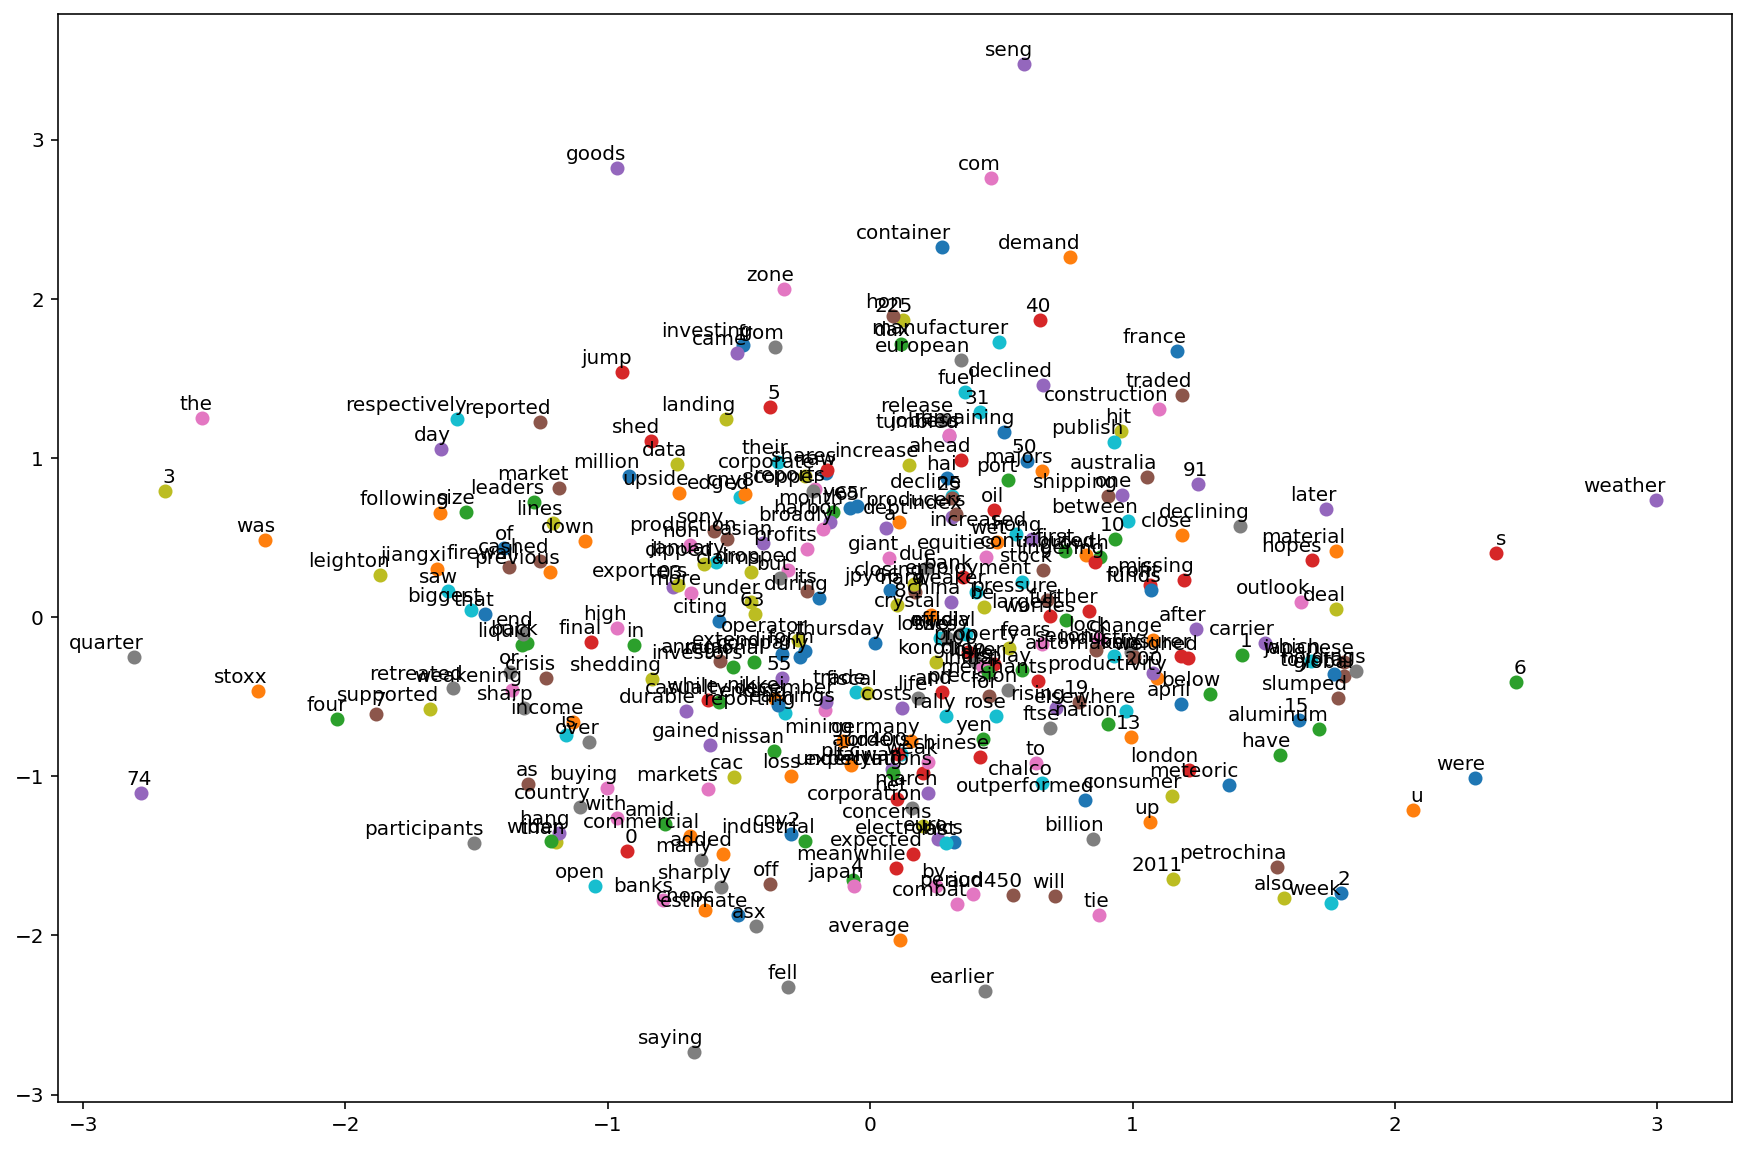

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(
        w, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom"
    )
plt.show()

### Evaluation

In [14]:
def CBOW_test(test_data, model):
    correct_ct = 0

    for context, target in data:
        context_vector = words_to_vector(context, word_to_ix)
        model.zero_grad()
        predicted = torch.argmax(model(context_vector), 1)

        if predicted[0] == torch.tensor([word_to_ix[target]]):
            correct_ct += 1

    print(
        "Accuracy: {:.1f}% ({:d}/{:d})".format(
            correct_ct / len(test_data) * 100, correct_ct, len(test_data)
        )
    )

In [15]:
CBOW_test(data, model)

Accuracy: 99.8% (570/571)


In [16]:
context = ["investing", "com", "stock", "markets"]
context_vector = words_to_vector(context, word_to_ix)
a = model(context_vector)

In [17]:
print(f"Context: {context}\n")
print(f"Prediction: {ix_to_word[torch.argmax(a[0]).item()]}")

Context: ['investing', 'com', 'stock', 'markets']

Prediction: asian


## Skip-gram model

The skip-gram model is the same as the CBOW model with one difference: it predicts the context words from the target word.

![](../figs/intro_nlp/embeddings/cbow_skip-gram.png)

In the above figure, $w[i]$ is the target word, and $w[i-2], w[i-1], w[i+1], w[i+2]$ are the context words, where $i$ is the location of the target word in the sentence.

The model predicts the probability of a word being a context word given the target word. The output probabilities explain how likely a word is to be close to the target word.

This shallow neural network architecture is called a `skip-gram` model because it predicts the context words from the target word.

We don't use this trained network for prediction. Instead, we use the weights of the embedding layer as the word embeddings.

### Input/output/hidden layer

How do we represent a single target word as a large vector?

- We can use a one-hot vector to represent the target word.
- Say we have a vocabulary of 10,000 words. Then the one-hot vector for the word “deep” will be a vector of 10,000 elements, where all the elements are 0 except the 4th element, which is 1.
- Similarly, the output layer will be a vector of 10,000 elements, where each element represents the probability of the word being the context word.
- The hidden layer is a linear layer that maps the one-hot vector to a vector of $d$ elements, where $d$ is the dimension of the word embeddings.
- The opimized weights of the hidden layer are the word embeddings.
- The dimensions of the hidden layer are $d \times V$, where $V$ is the size of the vocabulary.

![](../figs/intro_nlp/embeddings/skip-gram.png)


### Step 1: Setting target and context variable

Since skipgram takes a single context word and n number of target variables, we just need to flip the CBOW from the previous model.

when the window size is 1, we take one word before and after the target word.

For example, if we have the sentence “I like deep learning because it is fun”, and the window size is 1, the function will return the following list:

```python
[['like', 'I'],
 ['like', 'deep'],
 ['deep', 'like'],
 ['deep', 'learning'],
 ['learning', 'deep'],
 ['learning', 'because'],
 ...
]
```

In [60]:
def skipgram(words, window_size=1):
    skip_grams = []
    for i in range(window_size, len(words) - window_size):
        target = words[i]
        context = [words[i - window_size], words[i + window_size]]
        for w in context:
            skip_grams.append([target, w])

    return skip_grams

In [61]:
skipgram("I like deep learning because it is fun".split(), 1)

[['like', 'I'],
 ['like', 'deep'],
 ['deep', 'like'],
 ['deep', 'learning'],
 ['learning', 'deep'],
 ['learning', 'because'],
 ['because', 'learning'],
 ['because', 'it'],
 ['it', 'because'],
 ['it', 'is'],
 ['is', 'it'],
 ['is', 'fun']]

### Step 2: Building the model

In [62]:
class skipgramModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, word_to_ix):
        super(skipgramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.W = nn.Linear(embedding_size, embedding_size, bias=False)
        self.WT = nn.Linear(embedding_size, vocab_size, bias=False)
        self.word_to_ix = word_to_ix

    def forward(self, X):
        embeddings = self.embedding(X)
        hidden_layer = nn.functional.relu(self.W(embeddings))
        output_layer = self.WT(hidden_layer)
        return output_layer

    def get_word_emdedding(self, word):
        word = torch.tensor([self.word_to_ix[word]])
        return self.embedding(word).view(1, -1)

### Step 3: Loss and optimization function

In [65]:
import torch.optim as optim

word_list = list(set(words))
word_to_ix = {w: i for i, w in enumerate(word_list)}
ix_to_word = {i: w for w, i in word_to_ix.items()}
vocab_size = len(word_list)

batch_size = 2  # mini-batch size
embedding_size = 10  # embedding size

model = skipgramModel(vocab_size, embedding_size, word_to_ix)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Step 4: Training the model

In [66]:
import numpy as np
from tqdm.auto import tqdm


def random_batch(skip_grams, batch_size=2):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(skip_grams[i][0])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels


for epoch in tqdm(range(150000), total=len(skipgram(words))):
    input_batch, target_batch = random_batch(skipgram(words), batch_size)
    input_batch = torch.LongTensor(words_to_vector(input_batch, word_to_ix))
    target_batch = torch.LongTensor(words_to_vector(target_batch, word_to_ix))

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 10000 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "cost =", "{:.6f}".format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

  0%|          | 0/1146 [00:00<?, ?it/s]

Epoch: 10000 cost = 2.140910
Epoch: 20000 cost = 2.312550
Epoch: 30000 cost = 2.419060
Epoch: 40000 cost = 2.761508
Epoch: 50000 cost = 2.599850
Epoch: 60000 cost = 3.805832
Epoch: 70000 cost = 1.596720
Epoch: 80000 cost = 2.402641
Epoch: 90000 cost = 3.853763
Epoch: 100000 cost = 3.745454
Epoch: 110000 cost = 2.281985
Epoch: 120000 cost = 0.904178
Epoch: 130000 cost = 1.587507
Epoch: 140000 cost = 3.570252
Epoch: 150000 cost = 1.239178


### Visualizing the embeddings

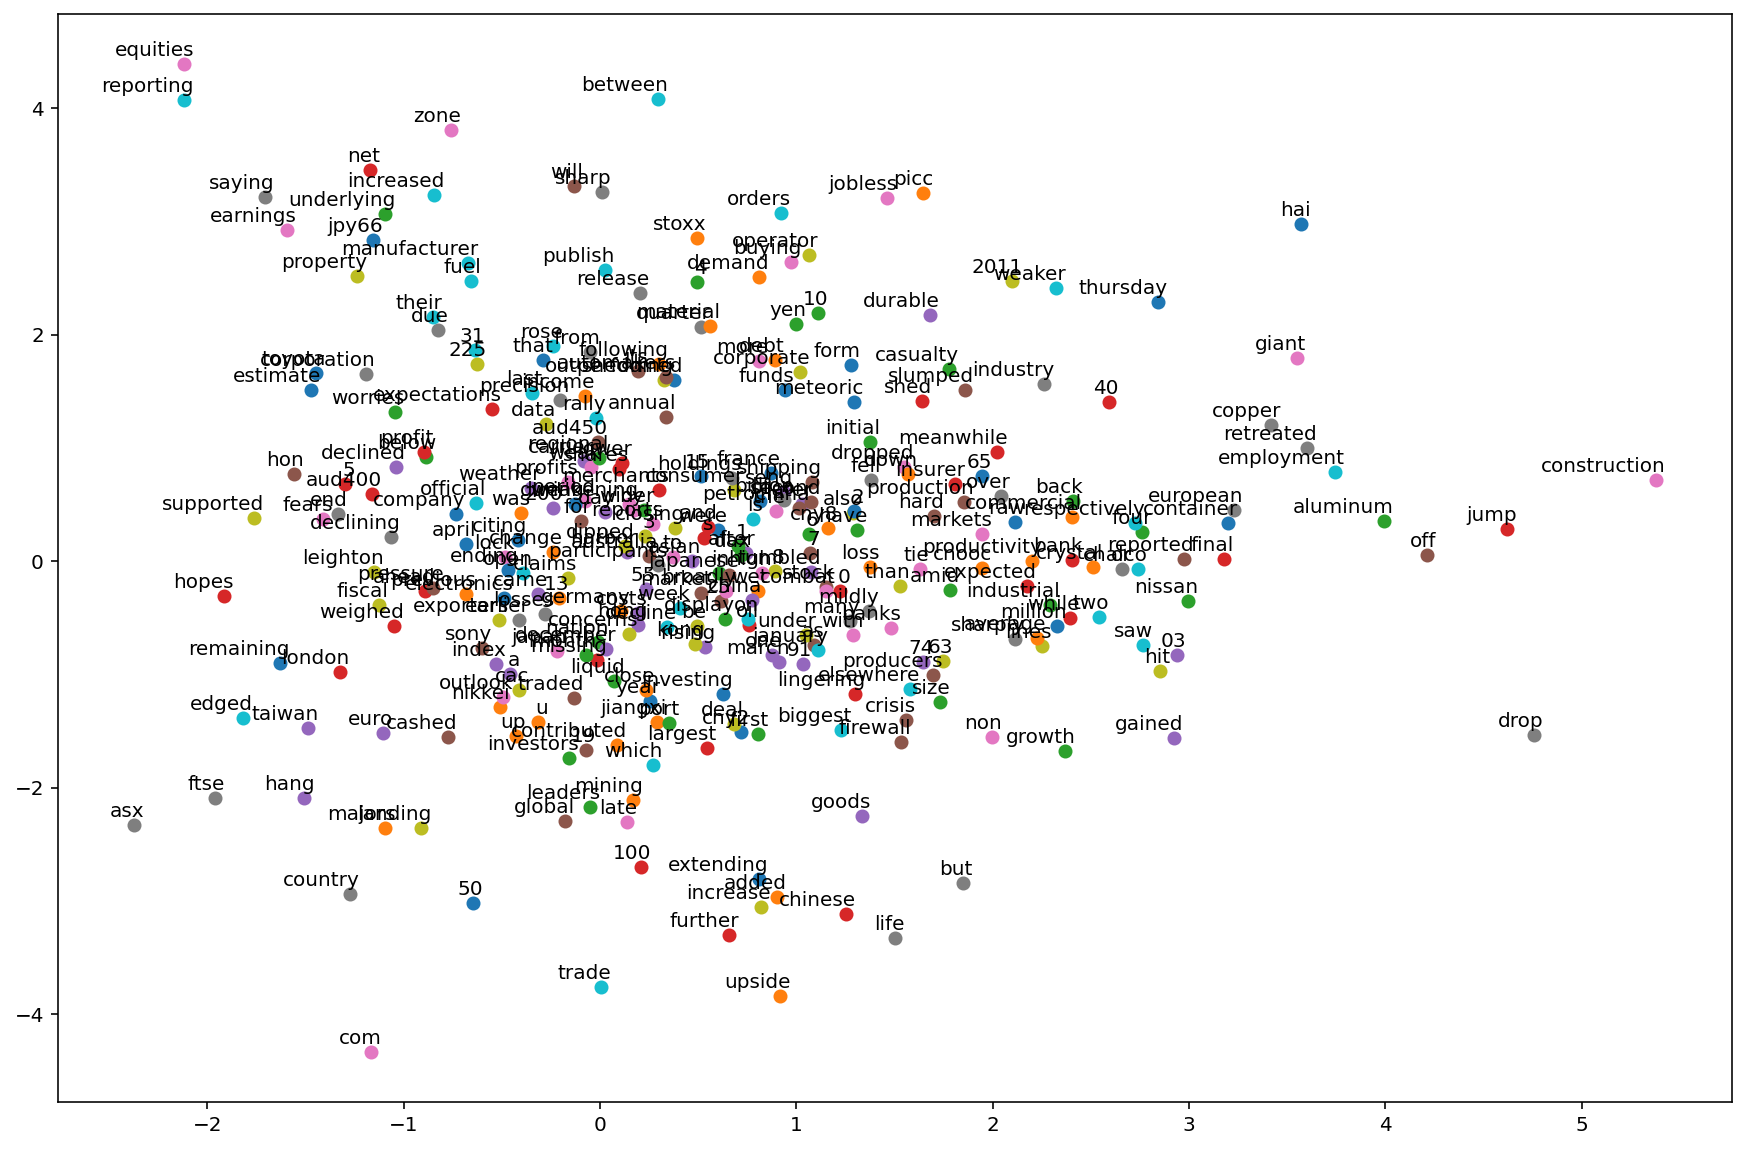

In [67]:
plt.figure(figsize=(15, 10))

for w in word_list:
    x = model.get_word_emdedding(w).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(
        w, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom"
    )
plt.show()

### Evaluation

In [68]:
def skipgram_test(test_data, model):
    correct_ct = 0

    for i in range(len(test_data)):
        input_batch, target_batch = random_batch(test_data, batch_size)
        input_batch = torch.LongTensor(words_to_vector(input_batch, word_to_ix))
        target_batch = torch.LongTensor(words_to_vector(target_batch, word_to_ix))

        model.zero_grad()
        _, predicted = torch.max(model(input_batch), 1)

        if predicted[0] == target_batch[0]:
            correct_ct += 1

    print(
        "Accuracy: {:.1f}% ({:d}/{:d})".format(
            correct_ct / len(test_data) * 100, correct_ct, len(test_data)
        )
    )

In [69]:
skipgram_test(skipgram(words), model)

Accuracy: 21.4% (245/1146)


In [70]:
pred = ["asian"]

model_pred = []
e = 0
model_pred.append(pred[0])

while e < 6:
    word = ix_to_word[
        torch.argmax(model(torch.LongTensor([word_to_ix[model_pred[-1]]]))).item()
    ]
    model_pred.append(word)
    e += 1

" ".join(model_pred)

'asian kong hong kong hong kong hong'

The skip-gram model increases computational complexity because it has to predict nearby words based on the number of neighboring words. The more distant words tend to be slightly less related to the current word.

## Improving predictive functions


### Softmax

The equation for the softmax function is:

$$
\begin{align}
\text{softmax}(x_i|c) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}
\end{align}
$$

where $x_i$ is the score of the target word $w_i$ and $c$ is the context words.

The complexity of the softmax function is $\mathcal{O}(n)$, where $n$ is the number of words in the vocabulary.

With a large vocabulary, say 100,000 words, the softmax function becomes very expensive to compute. For each word ($w_i$), we have to compute the exponential of the score of each word in the vocabulary ($x_j$) and then sum them up. This is $\mathcal{O}(n)$.

### Hierarchical softmax

Hierarchical softmax is a method to reduce the complexity of the softmax function. It is a tree-based data structure that is used to represent the vocabulary.

Hierarchical softmax was introduced by Morin and Bengio in 2005, as an alternative to the full softmax function, where it replaces it with a hierarchical layer. It borrows the technique from the binary huffman tree, which reduces the complexity of calculating the probability from $\mathcal{O}(n)$ to $\mathcal{O}(\log_2(n))$.

The hierarchical softmax is a binary tree, where each node represents a word in the vocabulary. The root node represents the entire vocabulary. The left child represents the words that are less frequent than the parent node, and the right child represents the words that are more frequent than the parent node.

The probability of a word $w_i$ is the product of the probabilities of the nodes on the path from the root to the leaf node that represents $w_i$.

In the huffman tree, we no longer calculate the output embeddings $w^\prime$. Instead, we calculate the probability of turning right or left at each node.

### Noise-contrastive estimation

Noise-contrastive estimation (NCE) is an approximation method to reduce the complexity of the softmax function. It is a sampling-based method that is used to approximate the softmax function.

NCE takes an unnormalised multinomial function (i.e. the function that has multiple labels and its output has not been passed through a softmax layer), and converts it to a binary logistic regression. 

In order to learn the distribution to predict the target word ($w_t$) from some specific context ($c$), we need to create two classes: **positive samples** and **negative samples**.

The positive class contains samples from training data distribution, while the negative class contains samples from a noise distribution $Q$, and we label them 1 and 0 respectively. Noise distribution is a unigram distribution of the training set. 

For every target word given context, we generate sample noise from the distribution $Q$ as $Q(w)$, such that it's $k$ times more frequent than the samples from the training data distribution $P(w|c)$.

The loss function is the sum of the log probabilities of the positive samples and the negative samples, and is given by:

$$
\begin{align}
\mathcal{L} = -\sum_{w_i \in V} \log \frac{e^{s_{\theta}(w|c)}}{e^{s_{\theta}(w|c)} + k Q(w)} + \sum_{j=1}^k \log[1-\frac{e^{s_{\theta}(\bar{w}_{ij}|c)}}{e^{s_{\theta}(\bar{w}_{ij}|c)} + k Q(\bar{w}_{ij})}]
\end{align}
$$

where $w_i$ is the $i$th negative sample.

As we increase the number of noise samples $k$, the NCE derivative approaches the likelihood gradient, or the softmax function of the normalised model.

In conclusion, NCE is a way of learning a data distribution by comparing it against a noise distribution, and modifying the learning parameters such that the model $P_{\theta}$ is closer to the noise $P_{\text{data}}$.

### Negative sampling

Negative sampling is a sampling-based method that is used to approximate the softmax function. It simplifies the NCE method by removing the need to calculate the noise distribution $Q$.

Negative sampling gets rid of the noise distribution $Q$ and uses a single noise sample $w_j$ for each target word $w_t$.

The loss function is the sum of the log probabilities of the positive samples and the negative samples, and is given by:

$$
\begin{align}
\mathcal{L} = -\sum_{w_i \in V} \log \sigma (s_{\theta}(w|c)) + \sum_{j=1}^k \log \sigma (-s_{\theta}(\bar{w}_{ij}|c))
\end{align}
$$

where $\sigma$ is the sigmoid function.

## GloVe

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. It is based on the co-occurrence matrix of words from a corpus.

GloVe stands for Global Vectors for Word Representation. It was introduced by {cite}`pennington2014glove` in 2014.


## FastText

FastText is an open-source library for learning of word representations and sentence classification. It was introduced by {cite}`bojanowski2016enriching` in 2016.

FastText is an extension of word2vec that allows us to learn word representations for out-of-vocabulary words. It is based on the skip-gram model, but it uses character n-grams as its input and output instead of words.


## References

- [Word2Vec](https://arxiv.org/abs/1301.3781)
- [FastText](https://fasttext.cc/)
- [A Visual Guide to FastText Word Embeddings](https://amitness.com/2020/06/fasttext-embeddings/)
- [Get FastText representation from pretrained embeddings with subword information](http://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html)
- [The Ultimate Guide to Word Embeddings](https://neptune.ai/blog/word-embeddings-guide)
